In [39]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from os import getcwd, listdir
import numpy as np
import pandas as pd
import hdf5storage
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat, loadmat
import math
from scipy.fftpack import fft,ifft
from scipy.stats import zscore, f_oneway
#import samplerate
import multiprocessing as mp
from scipy.signal import resample
import random
import pyreadr
from scipy import stats
import librosa
import librosa.display
from librosa import resample

# Import filter function
from neurodsp.filt import filter_signal

# Import simulation code for creating test data
from neurodsp.sim import sim_combined
from neurodsp.utils import set_random_seed, create_times

# Import utilities for loading and plotting data
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.time_series import plot_time_series

from scipy.signal import hilbert, chirp
import statsmodels.stats.multitest as multitest
import matplotlib.patches as mpatches


In [2]:
def get_info(field_num):
    field = []
    for item in range(trial_num):
        field.append(group_data['DATA'][0][item][field_num][0])
    return pd.DataFrame(field)

In [3]:
group_data = hdf5storage.loadmat(r"Z:\Commits\DBS_speech\Dev\U01SpikeAnalysis\data\group_data\group_data_narrow_09082021.mat")

trial_num = len(group_data['DATA'][0])

group_data = hdf5storage.loadmat(r"Z:\Commits\DBS_speech\Dev\U01SpikeAnalysis\data\group_data\group_data_narrow_09082021.mat")

trial_num = len(group_data['DATA'][0])

SubjectID = get_info(0)
SubjectID.columns = ['SubjectID']

session = get_info(1)
session.columns = ['session']

electrode = get_info(2)
electrode.columns = ['electrode']

unit_id = get_info(3)
unit_id.columns = ['unit_id']

unit = get_info(4)
unit.columns = ['unit']

RecType = get_info(5)
RecType.columns = ['RecType']

grade = get_info(6)
grade.columns = ['grade']

info = pd.concat([SubjectID, session, electrode, unit_id, unit, RecType, grade], axis=1)
info.head(2)
info.shape

,SubjectID,session,electrode,unit_id,unit,RecType,grade
0,DBS3001,1,micro_m,6,4,MU,B
1,DBS3001,2,micro_c,7,1,MU,C


(229, 7)

In [4]:
def get_produced_freq():
    produced_freq = pd.read_csv('all_freq.csv', index_col='id')
    d = {'ah':0, 'oo':1, 'ee':2}
    produced_freq['stim_factor'] = produced_freq.stim.map(d)
    produced_freq['spl'] = 20*np.log10(produced_freq['rms_audio_p'])
    produced_freq = produced_freq.dropna(0).reset_index(drop=1)

    produced_freq['before_time'] = np.nan
    for item in range(1, produced_freq.shape[0]):
        if produced_freq.syl_id[item] == 2:
            if produced_freq.syl_id[item-1] == 1:
                produced_freq.before_time[item] = produced_freq.starts[item] - produced_freq.ends[item-1]
        elif produced_freq.syl_id[item] == 3:
            if produced_freq.syl_id[item-1] == 2:
                produced_freq.before_time[item] = produced_freq.starts[item] - produced_freq.ends[item-1]

    for item in range(1, produced_freq.shape[0]):
        if produced_freq.syl_id[item] == 1:
            if produced_freq.syl_id[item+1] == 2:
                if produced_freq.syl_id[item+2] == 3:
                    produced_freq.before_time[item] = (produced_freq.before_time[item+1] + 
                                                       produced_freq.before_time[item+2])/2

    produced_freq.before_time[0] = (produced_freq.before_time[1] + produced_freq.before_time[2])/2
    produced_freq = produced_freq.dropna(0).reset_index(drop=1)
    return produced_freq

In [5]:
def get_df(time_point, neural_data, time_data, after=3.5, before=1.5, fs=1000):
    dfs = []
    time_point = time_point[time_point<time_data.max()-3.5][time_point>time_data.min()+3.5]
    for item in time_point:
        for i2 in range(len(neural_data)):
            if time_data[i2] > item:
                dfs.append(neural_data[i2-int(before*fs):i2+int(after*fs)])
                break
    return np.array(dfs)
produced_df = get_produced_freq()
produced_df.shape
produced_df.head(2)

(41210, 26)

,starts,ends,duration,cons_onset,trial_id,session_id,syl_id,channel,fundamental_freq,type,...,subject,freq2,discont,contrun_id,t,t2,t3,stim_factor,spl,before_time
0,36145.009713,36145.184457,0.174745,36145.009713,1,1,1,audio_p,142.196732,vowel,...,DBS3001,20219.910530,1,1,-195.420094,38189.013071,-7.462901e+06,0,-18.178208,0.404081
1,36145.494905,36145.643055,0.148150,36145.494905,1,1,2,audio_p,140.861581,vowel,...,DBS3001,19841.984898,0,1,-194.934901,37999.615755,-7.407451e+06,1,-21.894791,0.310448


In [6]:
def get_subj_table(produced_freq, number_elec, info, timing_subj, neural_subj):
    SUBJ = info.iloc[number_elec, 0]
    SESS = info.iloc[number_elec, 1]
    subj_table = produced_freq[produced_freq.subject == SUBJ].reset_index(drop=1)
    subj_table = subj_table[subj_table.session_id == SESS].reset_index(drop=1)
    subj_table = subj_table[subj_table.starts > timing_subj.min()+3.5].reset_index(drop=1)
    subj_table = subj_table[subj_table.starts < timing_subj.max()-3.5].reset_index(drop=1)

        
    subj_table['avg_spike'] = np.nan
    for trial in range(subj_table.shape[0]):
        if subj_table.ends[trial] < timing_subj.max() - 3.5:
            if subj_table.starts[trial] > timing_subj.min() + 3.5:
                subj_table.avg_spike[trial] = get_avg_spike(subj_table.iloc[trial], 
                                                            neural_subj, timing_subj)
    subj_table = subj_table.dropna(0).reset_index(drop=1)
    
    subj_table['t_z'] = (subj_table['t'] - subj_table['t'].mean())/subj_table['t'].std(ddof=0)
    stim_vol_mean = subj_table['stim_volume'].mean()
    subj_table['stim_vol_z'] = (subj_table['stim_volume'] - 
                                   stim_vol_mean)/subj_table['stim_volume'].std(ddof=0)
    if subj_table['stim_volume'].unique().shape[0]==1:
        subj_table['stim_vol_z'] = 0
        

    subj_table['syl_id_z'] = (subj_table['syl_id'] - 
                              subj_table['syl_id'].mean())/subj_table['syl_id'].std(ddof=0)
    subj_table['spl_z'] = (subj_table['spl'] - 
                           subj_table['spl'].mean())/subj_table['spl'].std(ddof=0)
    stim_fac_mean = subj_table['stim_factor'].mean()
    subj_table['stim_z'] = (subj_table['stim_factor'] - 
                                   stim_fac_mean)/subj_table['stim_factor'].std(ddof=0)
    fund_freq_mean = subj_table['fundamental_freq'].mean()
    subj_table['pitch_z'] = (subj_table['fundamental_freq'] - 
                             fund_freq_mean)/subj_table['fundamental_freq'].std(ddof=0)
    subj_table['pitch_spl_z'] = subj_table['pitch_z']*subj_table['spl_z']

    return subj_table

In [7]:
def get_subj_df_cue(subject, sess, subj_table):
    cue_df = pd.read_csv(f'Z:\DBS\\{subject}\Preprocessed Data\Sync\\annot\\{subject}_stimulus_syllable.txt', sep='	', index_col='id')
    cue_df = cue_df[cue_df['session_id']==sess].reset_index(drop=1)
    subj_table_cue = pd.merge(subj_table, cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")
    return subj_table_cue

def find_rest_time(subject_df):
    resting_time = subject_df[subject_df['syl_id'] == 1]['starts_y'] - 1
    return resting_time

def nansem(a, axis=1):
    return np.nanstd(a, axis=0)/np.sqrt(a.shape[axis])


In [8]:
def find_full_3_trial(subj_table):
    good_trial = []
    num_sess = len(subj_table['session_id'].unique())
    for item in subj_table['trial_id'].unique():
        if subj_table[subj_table['trial_id'] == item].shape[0]/num_sess == 3:
            good_trial.append(item)
    return subj_table[subj_table['trial_id'].isin(good_trial)]

In [11]:
xvals = np.linspace(-1, 3, 4000)

kernel_size = 100
kernel = np.ones(kernel_size) / kernel_size

In [10]:
def get_zscore(input_mat):
    rest_mat = input_mat[:, :500]
    input_mat_z = np.zeros(input_mat.shape)
    for item in range(rest_mat.shape[0]):
        rest_mean = rest_mat[item].mean()
        rest_sd = np.nanstd(rest_mat[item])
        input_mat_z[item] = (input_mat[item] - rest_mean)/rest_sd
    return input_mat_z

In [48]:
def plot_lfp(SUBJECT, f_low, f_high):
    f_range = (f_low, f_high)
    file_path = f'..\..\..\DBS\\{SUBJECT}\Preprocessed Data\FieldTrip'
    subj_mat = hdf5storage.loadmat(f"{file_path}\\{SUBJECT}_ft_raw_filt_trial_denoised.mat")['D'][0]
    
    chanlabel = []
    for item in range(subj_mat['label'].shape[0]):
        chanlabel.append(subj_mat['label'][item][0][0][0])
    chanlabel = np.array(chanlabel)

    fs = subj_mat['fsample'][0][0]
    nChans = len(subj_mat['label'])
    nTrials = len(subj_mat['trial'][0])

    ecog_chan = []
    for item in range(nChans):
        if chanlabel[item][:4] == "ecog":
            ecog_chan.append(item)

    dbs_chan = []
    for item in range(nChans):
        if chanlabel[item][:4] == "dbs_":
            dbs_chan.append(item)

    macro_chan = []
    for item in range(nChans):
        if chanlabel[item][:5] == "macro":
            macro_chan.append(item)

    micro_chan = []
    for item in range(nChans):
        if chanlabel[item][:5] == "micro":
            micro_chan.append(item)

    time_mat = subj_mat['time'][0]
    trial_mat = subj_mat['trial'][0]

    subject_table = produced_df[produced_df.subject == SUBJECT].reset_index(drop=1)
    subject_table = find_full_3_trial(subject_table).reset_index(drop=1)
    subject_table = subject_table[subject_table.syl_id == 1].reset_index(drop=1)

    cue_df = pd.read_csv(f'Z:\DBS\\{SUBJECT}\Preprocessed Data\Sync\\annot\\{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
    subj_df_cue = pd.merge(subject_table, cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

    dbs_mat = np.zeros((subj_df_cue.shape[0], len(dbs_chan), 4000))
    macro_mat = np.zeros((subj_df_cue.shape[0], len(macro_chan), 4000))
    ecog_mat = np.zeros((subj_df_cue.shape[0], len(ecog_chan), 4000))
    micro_mat = np.zeros((subj_df_cue.shape[0], len(micro_chan), 4000))


    for item in range(subj_df_cue.shape[0]):
        time_point = subj_df_cue.iloc[item].starts_y
        for i2 in range(nTrials):
            time_min = time_mat[i2][0].min()
            time_max = time_mat[i2][0].max()
            if (time_point < time_max - 3) and (time_point > time_min + 1):
                for i3 in range(len(time_mat[i2][0])):
                    if time_mat[i2][0][i3] > time_point:
                        if len(dbs_chan)> 0:
                            sig_filt = trial_mat[i2][dbs_chan]
                            sig_filt = filter_signal(sig_filt, fs, 'bandpass', f_range)
                            sig_filt = np.nan_to_num(sig_filt)
                            analytic_signal = hilbert(sig_filt)
                            amplitude_envelope = np.abs(analytic_signal)
                            dbs_mat[item] = amplitude_envelope[:, i3-1000:i3+3000]
                        if len(macro_chan)> 0:
                            sig_filt = trial_mat[i2][macro_chan]
                            sig_filt = filter_signal(sig_filt, fs, 'bandpass', f_range)
                            sig_filt = np.nan_to_num(sig_filt)
                            analytic_signal = hilbert(sig_filt)
                            amplitude_envelope = np.abs(analytic_signal)
                            macro_mat[item] = amplitude_envelope[:, i3-1000:i3+3000]
                        if len(ecog_chan)> 0:
                            sig_filt = trial_mat[i2][ecog_chan]
                            sig_filt = filter_signal(sig_filt, fs, 'bandpass', f_range)
                            sig_filt = np.nan_to_num(sig_filt)
                            analytic_signal = hilbert(sig_filt)
                            amplitude_envelope = np.abs(analytic_signal)
                            ecog_mat[item] = amplitude_envelope[:, i3-1000:i3+3000]
                        if len(micro_chan)> 0:
                            sig_filt = trial_mat[i2][micro_chan]
                            sig_filt = filter_signal(sig_filt, fs, 'bandpass', f_range)
                            sig_filt = np.nan_to_num(sig_filt)
                            analytic_signal = hilbert(sig_filt)
                            amplitude_envelope = np.abs(analytic_signal)
                            micro_mat[item] = amplitude_envelope[:, i3-1000:i3+3000]
                        break
                        break
                        
    total_channel = 0
    total_channel += ecog_mat.shape[1]
    total_channel += dbs_mat.shape[1]
    total_channel += macro_mat.shape[1]
    total_channel += micro_mat.shape[1]
    total_channel
                        
    ncol = int(np.sqrt(total_channel))
    nrow = int(total_channel/ncol)+1

    fig, axs = plt.subplots(ncol, nrow, figsize=(nrow*2, ncol*1.25))
    axs = axs.flatten()
    plt.tight_layout()

    start_loc = 0
    if len(ecog_chan)> 0:
        for elec in range(ecog_mat.shape[1]):
            elec_mat = ecog_mat[:, elec]
            elec_mat = elec_mat[~np.all(elec_mat == 0, axis=1)]
            elec_mat_z = get_zscore(elec_mat)
            mean = elec_mat_z.mean(axis=0)
            mean = np.convolve(mean, kernel, mode='same')
            sem = nansem(elec_mat_z, axis=0)
            axs[elec + start_loc].plot(xvals, mean)
            axs[elec + start_loc].fill_between(xvals, mean-sem, mean+sem, alpha=0.5)
            axs[elec + start_loc].set(yticklabels=[], xticklabels=[], xticks=[0, 1])
            axs[elec + start_loc].text(0.5, 1, chanlabel[ecog_chan][elec], 
                                       transform=axs[elec].transAxes, fontsize=15)
            axs[elec + start_loc].axvline(0, color='k', linewidth=1)
            axs[elec + start_loc].axvline(1.5, color='k', linewidth=1)
            
            rest_mat = elec_mat_z[:, :500].ravel()
            rest_mean = rest_mat.mean()
            rest_std = np.nanstd(rest_mat, axis=0)
            rest_compare = rest_std * np.random.randn(100, 4000) + rest_mean
            significance = pd.DataFrame({"xvals":xvals, "pval":f_oneway(elec_mat_z, rest_compare).pvalue})
            patch_y = axs[elec + start_loc].get_ylim()[1] - axs[elec + start_loc].get_ylim()[0]
            for item in range(len(xvals)):
                if multitest.fdrcorrection(significance.pval)[0][item] == True:
                    axs[elec + start_loc].add_patch(mpatches.Rectangle((item/1000-1, axs[elec + start_loc].get_ylim()[0]), 
                                                              0.001, patch_y, color='grey', alpha=0.5, ec=None))

    start_loc += ecog_mat.shape[1]
    if len(dbs_chan)> 0:
        for elec in range(dbs_mat.shape[1]):
            elec_mat = dbs_mat[:, elec]
            elec_mat = elec_mat[~np.all(elec_mat == 0, axis=1)]
            elec_mat_z = get_zscore(elec_mat)
            mean = elec_mat_z.mean(axis=0)
            mean = np.convolve(mean, kernel, mode='same')
            sem = nansem(elec_mat_z, axis=0)
            axs[elec + start_loc].plot(xvals, mean)
            axs[elec + start_loc].fill_between(xvals, mean-sem, mean+sem, alpha=0.5)
            axs[elec + start_loc].set(yticklabels=[], xticklabels=[], xticks=[0, 1])
            axs[elec + start_loc].text(0.5, 1, chanlabel[dbs_chan][elec], 
                                       transform=axs[elec + start_loc].transAxes, fontsize=15)
            axs[elec + start_loc].axvline(0, color='k', linewidth=1)
            axs[elec + start_loc].axvline(1.5, color='k', linewidth=1)
            
            rest_mat = elec_mat_z[:, :500].ravel()
            rest_mean = rest_mat.mean()
            rest_std = np.nanstd(rest_mat, axis=0)
            rest_compare = rest_std * np.random.randn(100, 4000) + rest_mean
            significance = pd.DataFrame({"xvals":xvals, "pval":f_oneway(elec_mat_z, rest_compare).pvalue})
            patch_y = axs[elec + start_loc].get_ylim()[1] - axs[elec + start_loc].get_ylim()[0]
            for item in range(len(xvals)):
                if multitest.fdrcorrection(significance.pval)[0][item] == True:
                    axs[elec + start_loc].add_patch(mpatches.Rectangle((item/1000-1, axs[elec + start_loc].get_ylim()[0]), 
                                                              0.001, patch_y, color='grey', alpha=0.5, ec=None))

    start_loc += dbs_mat.shape[1]
    if len(macro_chan)> 0:
        for elec in range(macro_mat.shape[1]):
            elec_mat = macro_mat[:, elec]
            elec_mat = elec_mat[~np.all(elec_mat == 0, axis=1)]
            elec_mat_z = get_zscore(elec_mat)
            mean = elec_mat_z.mean(axis=0)
            mean = np.convolve(mean, kernel, mode='same')
            sem = nansem(elec_mat_z, axis=0)
            axs[elec + start_loc].plot(xvals, mean)
            axs[elec + start_loc].fill_between(xvals, mean-sem, mean+sem, alpha=0.5)
            axs[elec + start_loc].set(yticklabels=[], xticklabels=[], xticks=[0, 1])
            axs[elec + start_loc].text(0.5, 1, chanlabel[macro_chan][elec], 
                                       transform=axs[elec + start_loc].transAxes, fontsize=15)
            axs[elec + start_loc].axvline(0, color='k', linewidth=1)
            axs[elec + start_loc].axvline(1.5, color='k', linewidth=1)
            
            rest_mat = elec_mat_z[:, :500].ravel()
            rest_mean = rest_mat.mean()
            rest_std = np.nanstd(rest_mat, axis=0)
            rest_compare = rest_std * np.random.randn(100, 4000) + rest_mean
            significance = pd.DataFrame({"xvals":xvals, "pval":f_oneway(elec_mat_z, rest_compare).pvalue})
            patch_y = axs[elec + start_loc].get_ylim()[1] - axs[elec + start_loc].get_ylim()[0]
            for item in range(len(xvals)):
                if multitest.fdrcorrection(significance.pval)[0][item] == True:
                    axs[elec + start_loc].add_patch(mpatches.Rectangle((item/1000-1, axs[elec + start_loc].get_ylim()[0]), 
                                                              0.001, patch_y, color='grey', alpha=0.5, ec=None))

    start_loc += macro_mat.shape[1]
    if len(micro_chan)> 0:
        for elec in range(micro_mat.shape[1]):
            elec_mat = micro_mat[:, elec]
            elec_mat = elec_mat[~np.all(elec_mat == 0, axis=1)]
            elec_mat_z = get_zscore(elec_mat)
            mean = elec_mat_z.mean(axis=0)
            mean = np.convolve(mean, kernel, mode='same')
            sem = nansem(elec_mat_z, axis=0)
            axs[elec + start_loc].plot(xvals, mean)
            axs[elec + start_loc].fill_between(xvals, mean-sem, mean+sem, alpha=0.5)
            axs[elec + start_loc].set(yticklabels=[], xticklabels=[], xticks=[0, 1])
            axs[elec + start_loc].text(0.5, 1, chanlabel[micro_chan][elec], 
                                       transform=axs[elec + start_loc].transAxes, fontsize=15)
            axs[elec + start_loc].axvline(0, color='k', linewidth=1)
            axs[elec + start_loc].axvline(1.5, color='k', linewidth=1)
            
            rest_mat = elec_mat_z[:, :500].ravel()
            rest_mean = rest_mat.mean()
            rest_std = np.nanstd(rest_mat, axis=0)
            rest_compare = rest_std * np.random.randn(100, 4000) + rest_mean
            significance = pd.DataFrame({"xvals":xvals, "pval":f_oneway(elec_mat_z, rest_compare).pvalue})
            patch_y = axs[elec + start_loc].get_ylim()[1] - axs[elec + start_loc].get_ylim()[0]
            for item in range(len(xvals)):
                if multitest.fdrcorrection(significance.pval)[0][item] == True:
                    axs[elec + start_loc].add_patch(mpatches.Rectangle((item/1000-1, axs[elec + start_loc].get_ylim()[0]), 
                                                              0.001, patch_y, color='grey', alpha=0.5, ec=None))

    start_loc += micro_mat.shape[1]
    for i in range(start_loc, ncol*nrow):
        sns.despine(top=True, right=True, left=True, bottom=True, ax=axs[i])
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    
    plt.suptitle(SUBJECT + f" LFP band {f_low}-{f_high} Hz");
    plt.savefig(f'cue_lfp_band_z_smooth\\{SUBJECT}_{f_low}-{f_high}.jpeg', dpi=200)
    plt.close(fig);
    #plt.show();

In [44]:
dbs_subj = listdir('..\..\..\DBS')
dbs_30s = [i for i in dbs_subj if i.startswith('DBS30')]

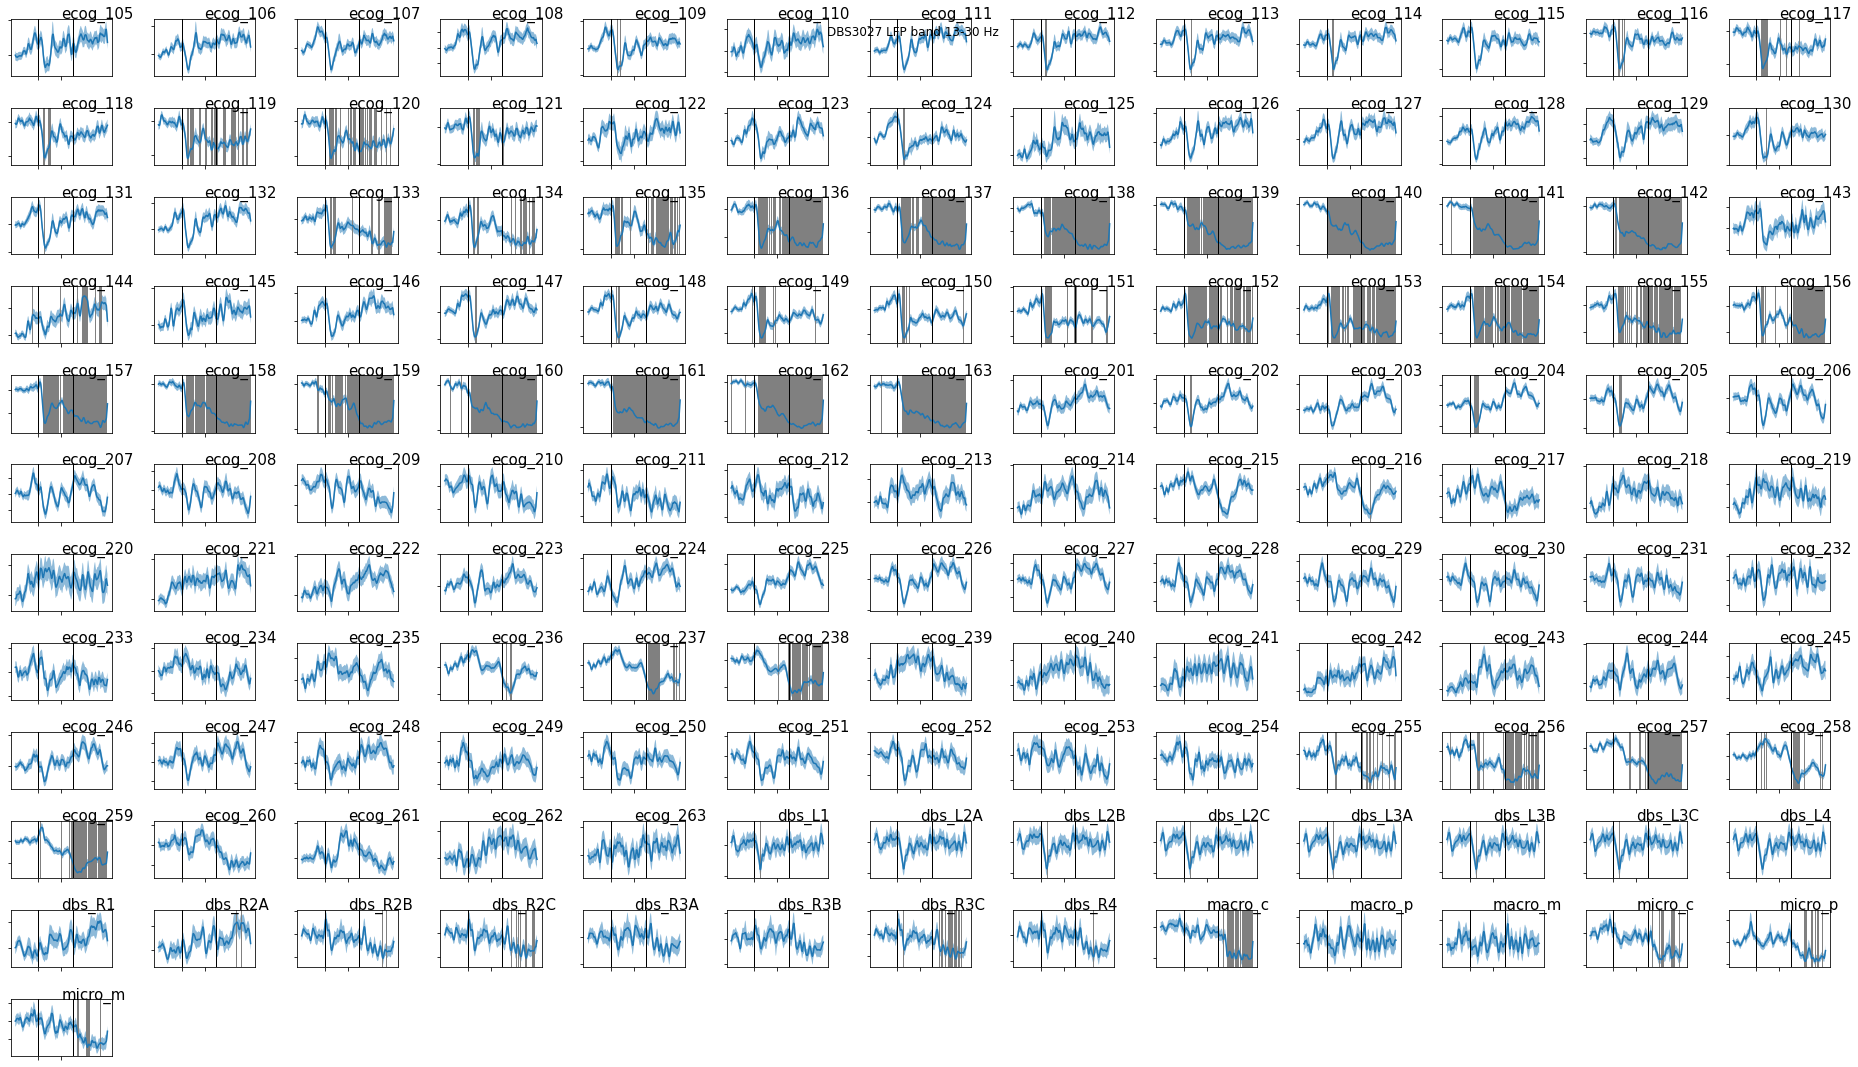

In [45]:
plot_lfp("DBS3027", 13, 30)

In [49]:
for item in dbs_30s[2:]:
    print(item)
    plot_lfp(item, 8, 12)

plt.close();

DBS3003
DBS3004
DBS3005
DBS3006
DBS3008
DBS3010
DBS3011
DBS3012
DBS3014
DBS3015
DBS3016
DBS3017
DBS3018
DBS3019
DBS3020
DBS3021
DBS3022
DBS3023
DBS3024
DBS3025
DBS3026
DBS3027
DBS3028
DBS3029
DBS3030
DBS3031
DBS3032


In [50]:
for item in dbs_30s[2:]:
    print(item)
    plot_lfp(item, 13, 30)

plt.close();

DBS3003
DBS3004
DBS3005
DBS3006
DBS3008
DBS3010
DBS3011
DBS3012
DBS3014
DBS3015
DBS3016
DBS3017
DBS3018
DBS3019
DBS3020
DBS3021
DBS3022
DBS3023
DBS3024
DBS3025
DBS3026
DBS3027
DBS3028
DBS3029
DBS3030
DBS3031
DBS3032


In [51]:
for item in dbs_30s[2:]:
    print(item)
    plot_lfp(item, 30, 70)

plt.close();

DBS3003
DBS3004
DBS3005
DBS3006
DBS3008
DBS3010
DBS3011
DBS3012
DBS3014
DBS3015
DBS3016
DBS3017
DBS3018
DBS3019
DBS3020
DBS3021
DBS3022
DBS3023
DBS3024
DBS3025
DBS3026
DBS3027
DBS3028
DBS3029
DBS3030
DBS3031
DBS3032


In [52]:
for item in dbs_30s[2:]:
    print(item)
    plot_lfp(item, 70, 150)

plt.close();

DBS3003
DBS3004
DBS3005
DBS3006
DBS3008
DBS3010
DBS3011
DBS3012
DBS3014
DBS3015
DBS3016
DBS3017
DBS3018
DBS3019
DBS3020
DBS3021
DBS3022
DBS3023
DBS3024
DBS3025
DBS3026
DBS3027
DBS3028
DBS3029
DBS3030
DBS3031
DBS3032


In [53]:
for item in dbs_30s[2:]:
    print(item)
    plot_lfp(item, 4, 8)

plt.close();

DBS3003
DBS3004
DBS3005
DBS3006
DBS3008
DBS3010
DBS3011
DBS3012
DBS3014
DBS3015
DBS3016
DBS3017
DBS3018
DBS3019
DBS3020
DBS3021
DBS3022
DBS3023
DBS3024
DBS3025
DBS3026
DBS3027
DBS3028
DBS3029
DBS3030
DBS3031
DBS3032
